In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import models
import torchvision.transforms as T

import numpy as np
import utils
from utils import ImagePair, ImageMatcher
import h5py
from scipy.spatial.transform import Rotation as Rot

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Load a pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
).eval().to(device)

Device: cpu


In [7]:
DATA_DIR = '/Users/richard/Desktop/Dataset/'
frames = utils.load_video(DATA_DIR + '3-2-v002-t023.mp4', grayscale=False)
assert len(frames) > 0

In [ ]:
frame = frames[250]
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
def segment_frames_in_batches(frames, batch_size, device):
    num_frames = len(frames)
    human_segmentation_masks = []
    transform = T.Compose([T.ToTensor()])

    for i in range(0, num_frames, batch_size):
        # Get the batch of frames
        batch_frames = frames[i:i + batch_size]

        # Apply transformation and stack frames into a batch
        batch = torch.stack([transform(frame) for frame in batch_frames]).to(device)

        with torch.no_grad():
            outputs = model(batch)['out']

        # Get the segmentation masks for the human class and move them back to the CPU
        batch_masks = [(output.argmax(0) == 15).cpu().numpy() for output in outputs]
        human_segmentation_masks.extend(batch_masks)

    return np.array(human_segmentation_masks)


In [17]:
masks = segment_frames_in_batches(frames[:2], batch_size=2, device=device)

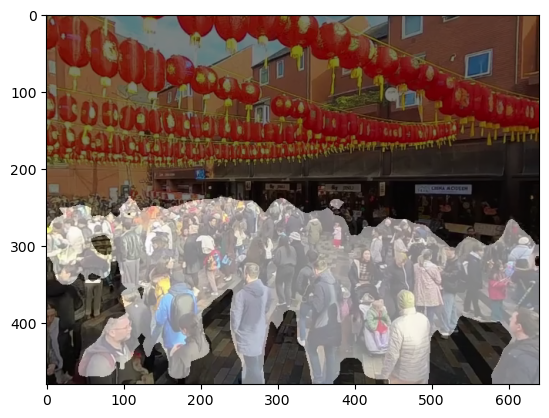

In [19]:
plt.imshow(cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB))
plt.imshow(masks[1], cmap='gray', alpha=0.5)
plt.show()

In [20]:
np.savez_compressed('masks.npz', masks=masks)